# Import Packages

In [ ]:
# Import Operational Packages
import pandas as pd
import numpy as np

# Import Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data Pre-processing, Modeling, and Evaluation Packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
import optuna
import tqdm
from functions import (
    run_chi2_test, 
    generate_barplot,
    generate_boxplot,
    clean_string,
    clean_binary,
    scale_data,
    select_all_features,
    split_data
)

%load_ext autoreload
%autoreload 2

# Import Data

In [2]:
# Import Data
df = pd.read_parquet("./data/full_data_set.parquet")
data_descriptions = pd.read_csv("./data/data_descriptions.csv")

# Features that could either provide no data or are potentially
# protected classes
features_to_remove = ["LoanID", "Age", "MaritalStatus", "HasDependents"]

df.drop(columns=features_to_remove, inplace=True)

In [3]:
df.head(10)

,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,HasMortgage,LoanPurpose,HasCoSigner,Default
0,131645,43797,802,23,2,6.10,24,0.13,High School,Full-time,Yes,Other,No,NaN
1,134312,18402,369,87,2,12.99,60,0.59,High School,Self-employed,No,Business,Yes,NaN
2,115809,151774,563,3,3,5.51,48,0.82,Bachelor's,Full-time,Yes,Other,Yes,NaN
3,94970,55789,337,24,1,23.93,36,0.77,Bachelor's,Unemployed,No,Business,No,NaN
4,71727,189798,451,52,3,22.05,48,0.44,PhD,Unemployed,Yes,Auto,No,NaN
5,43593,196031,442,89,3,19.75,60,0.68,PhD,Part-time,Yes,Education,No,NaN
6,72699,32179,624,82,2,6.45,24,0.67,Bachelor's,Full-time,Yes,Education,No,NaN
7,32150,101882,642,107,3,12.82,12,0.66,PhD,Unemployed,No,Business,Yes,NaN
8,128139,11560,378,105,1,22.84,36,0.32,High School,Full-time,Yes,Other,Yes,NaN
9,134889,172152,388,2,1,13.28,12,0.67,Bachelor's,Full-time,Yes,Other,No,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364782 entries, 0 to 364781
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Income          364782 non-null  int64  
 1   LoanAmount      364782 non-null  int64  
 2   CreditScore     364782 non-null  int64  
 3   MonthsEmployed  364782 non-null  int64  
 4   NumCreditLines  364782 non-null  int64  
 5   InterestRate    364782 non-null  float64
 6   LoanTerm        364782 non-null  int64  
 7   DTIRatio        364782 non-null  float64
 8   Education       364782 non-null  object 
 9   EmploymentType  364782 non-null  object 
 10  HasMortgage     364782 non-null  object 
 11  LoanPurpose     364782 non-null  object 
 12  HasCoSigner     364782 non-null  object 
 13  Default         255347 non-null  float64
dtypes: float64(3), int64(6), object(5)
memory usage: 39.0+ MB


In [5]:
df.isna().sum()

Income                 0
LoanAmount             0
CreditScore            0
MonthsEmployed         0
NumCreditLines         0
InterestRate           0
LoanTerm               0
DTIRatio               0
Education              0
EmploymentType         0
HasMortgage            0
LoanPurpose            0
HasCoSigner            0
Default           109435
dtype: int64

In [6]:
df['Default'].value_counts(dropna=False, normalize=True)

Default
0.0    0.618709
NaN    0.300001
1.0    0.081290
Name: proportion, dtype: float64

30% of the data in the target variable (Default) is null. Because of the huge differences (61.8% 0, 8.1% 1, and 30.0% NULL), we can't safely drop the null values without potentially impacting model performance. We need to determine to which group these null values belong.

We are going to build a predictive model with just the records for which we know the values (0, 1) and then apply that model to the null values. Depending on how the data falls, we are going to use that to inform how we are going to impute values and rebuild a more complete model.

In [7]:
df_defaultNotNull = df[~df['Default'].isna()].copy()
df_defaultNull = df[df['Default'].isna()].copy()

df_defaultNotNull.reset_index(drop=True, inplace=True)
df_defaultNull.reset_index(drop=True, inplace=True)

# Categorical Variables

## Credit Score

In [8]:
# Based Upon Credit Rating Labels from Equifax
bins = [299, 580, 670, 740, 800, 850]
labels = ["POOR", "FAIR", "GOOD", "VERY_GOOD", "EXCELLENT"]

df_defaultNotNull['credit_score'] = pd.cut(df_defaultNotNull['CreditScore'], bins=bins, labels=labels)

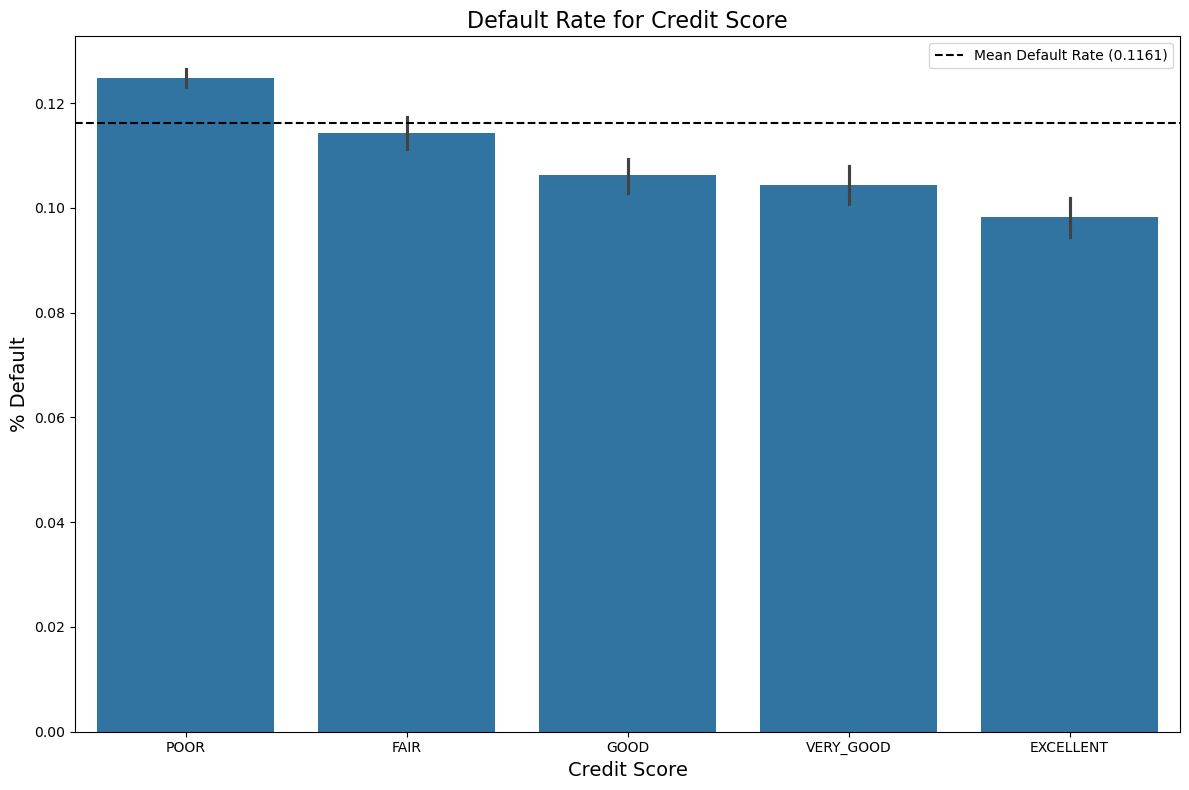

In [9]:
generate_barplot('credit_score', 'Default', df_defaultNotNull)

In [10]:
run_chi2_test(ind_variable='credit_score', dep_variable='Default', df=df_defaultNotNull)

Chi-Squared Test Results:
	Chi-Squared Statistic: 234.5576
	P-Value: 1.3784174777249786e-49
	Degrees of Freedom: 4

Result: There is a statistically significant association between the variables.


## Number of Credit Lines

In [11]:
df_defaultNotNull['NumCreditLines'].value_counts()

NumCreditLines
2    64130
3    63834
4    63829
1    63554
Name: count, dtype: int64

In [12]:
ordinal = OrdinalEncoder()
df_defaultNotNull['num_credit_lines'] = ordinal.fit_transform(
    df_defaultNotNull[["NumCreditLines"]]
).flatten()

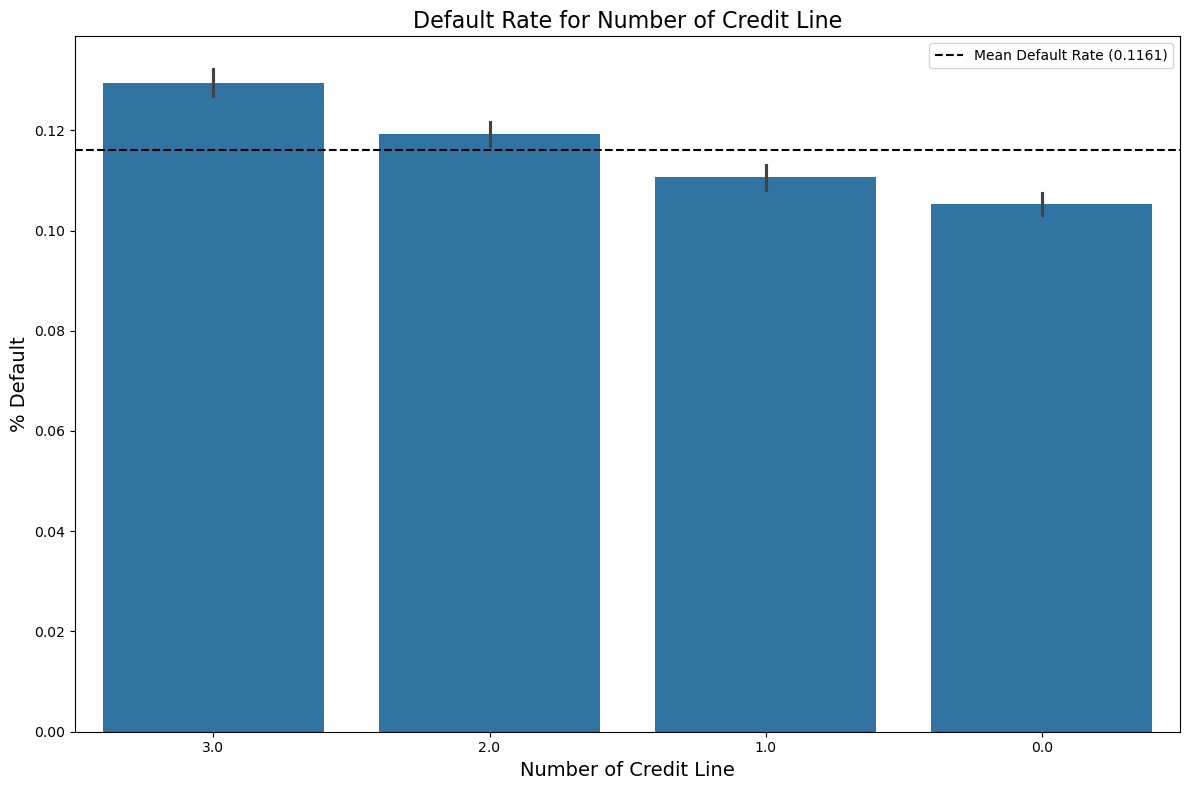

In [13]:
generate_barplot('num_credit_lines', 'Default', df_defaultNotNull, "Number of Credit Line")

In [14]:
run_chi2_test('num_credit_lines', 'Default', df_defaultNotNull)

Chi-Squared Test Results:
	Chi-Squared Statistic: 208.6514
	P-Value: 5.696814971390997e-45
	Degrees of Freedom: 3

Result: There is a statistically significant association between the variables.


## Loan Term

In [15]:
df_defaultNotNull["LoanTerm"].unique()

array([36, 60, 24, 48, 12])

In [16]:
df_defaultNotNull['loan_term'] = ordinal.fit_transform(df_defaultNotNull[['LoanTerm']]).flatten()

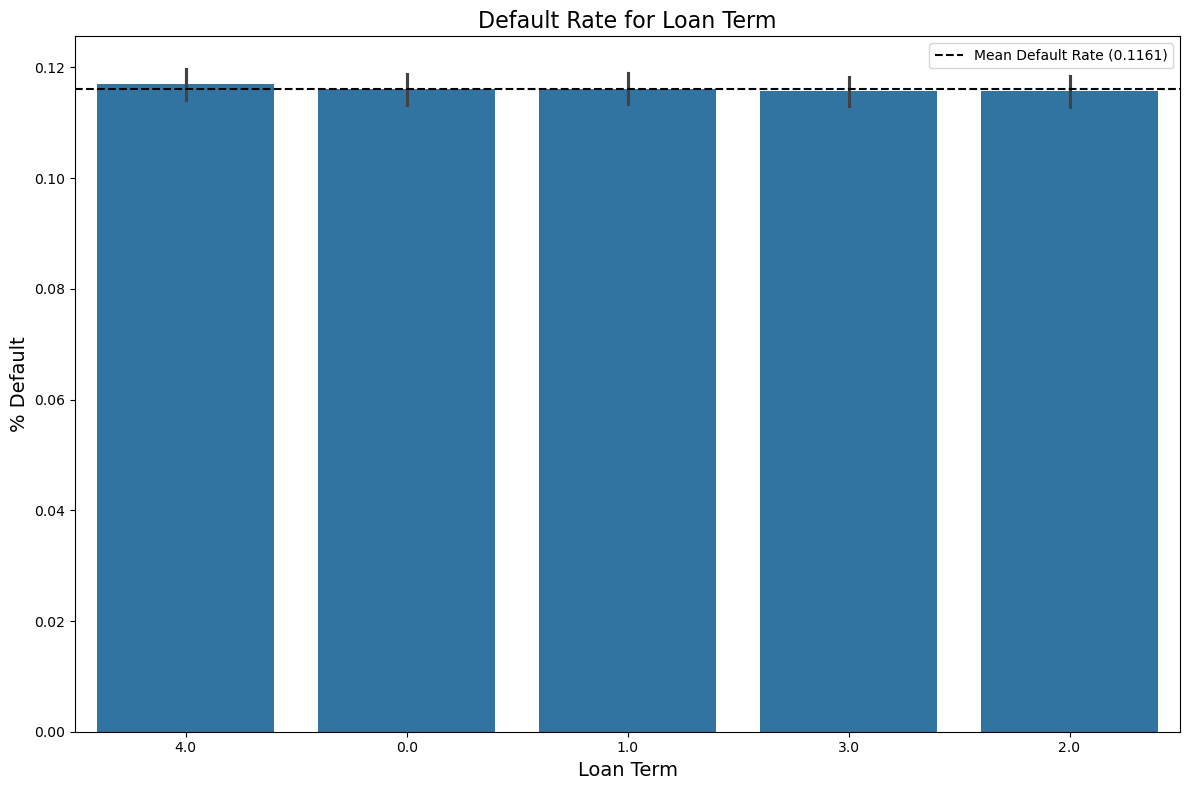

In [17]:
generate_barplot('loan_term', 'Default', df_defaultNotNull)

In [18]:
run_chi2_test('loan_term', 'Default', df_defaultNotNull)

Chi-Squared Test Results:
	Chi-Squared Statistic: 0.5201
	P-Value: 0.9715138020772133
	Degrees of Freedom: 4

Result: No statistically significant association between the variables.


## Education

In [19]:
df_defaultNotNull["Education"].value_counts()

Education
Bachelor's     64366
High School    63903
Master's       63541
PhD            63537
Name: count, dtype: int64

In [20]:
df_defaultNotNull['education'] = clean_string('Education', df_defaultNotNull)

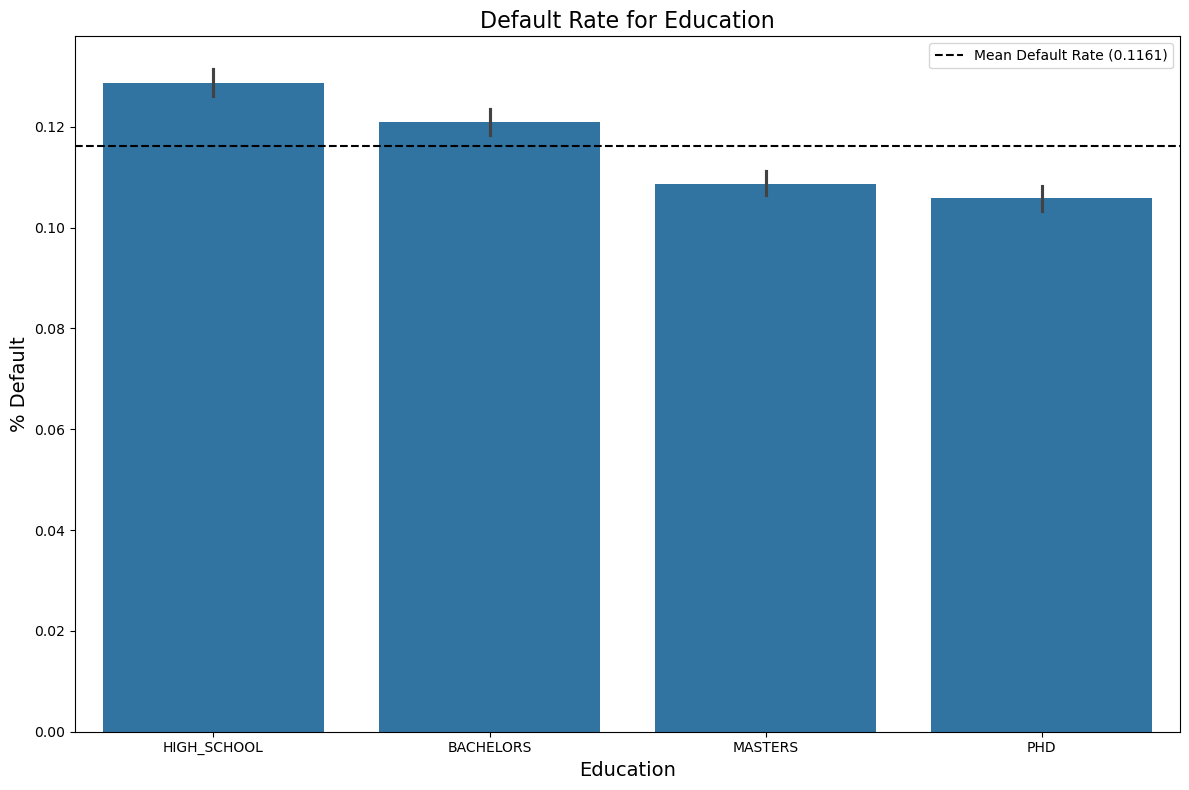

In [21]:
generate_barplot('education', 'Default', df_defaultNotNull)

In [22]:
run_chi2_test('education', 'Default', df_defaultNotNull)

Chi-Squared Test Results:
	Chi-Squared Statistic: 214.0190
	P-Value: 3.940486417550871e-46
	Degrees of Freedom: 3

Result: There is a statistically significant association between the variables.


## Employment Type

In [23]:
df_defaultNotNull["EmploymentType"].value_counts()

EmploymentType
Part-time        64161
Unemployed       63824
Self-employed    63706
Full-time        63656
Name: count, dtype: int64

In [24]:
df_defaultNotNull['employment_type'] = clean_string("EmploymentType", df_defaultNotNull)

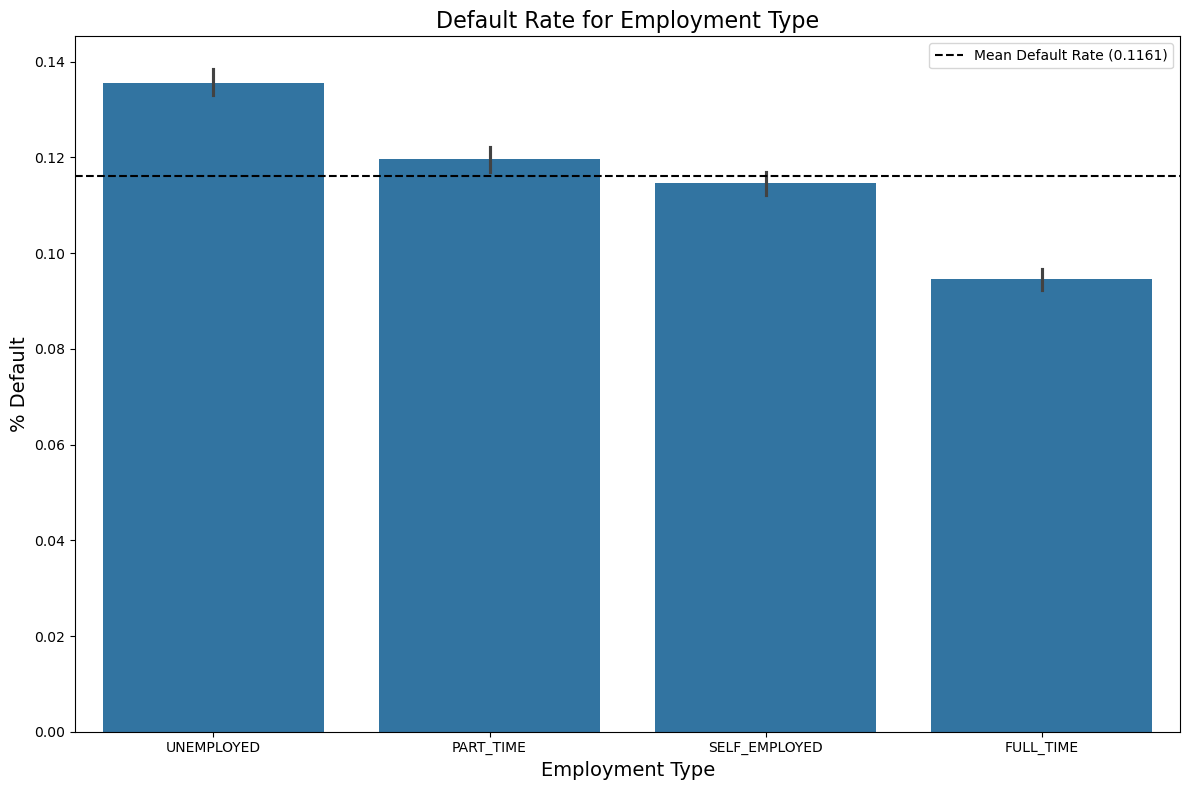

In [25]:
generate_barplot('employment_type', 'Default', df_defaultNotNull)

In [26]:
run_chi2_test('employment_type', 'Default', df_defaultNotNull)

Chi-Squared Test Results:
	Chi-Squared Statistic: 529.7449
	P-Value: 1.7066378020433157e-114
	Degrees of Freedom: 3

Result: There is a statistically significant association between the variables.


## Mortgage

In [27]:
df_defaultNotNull['HasMortgage'].value_counts()

HasMortgage
Yes    127677
No     127670
Name: count, dtype: int64

In [28]:
df_defaultNotNull['has_mortgage'] = clean_binary('HasMortgage', df_defaultNotNull)

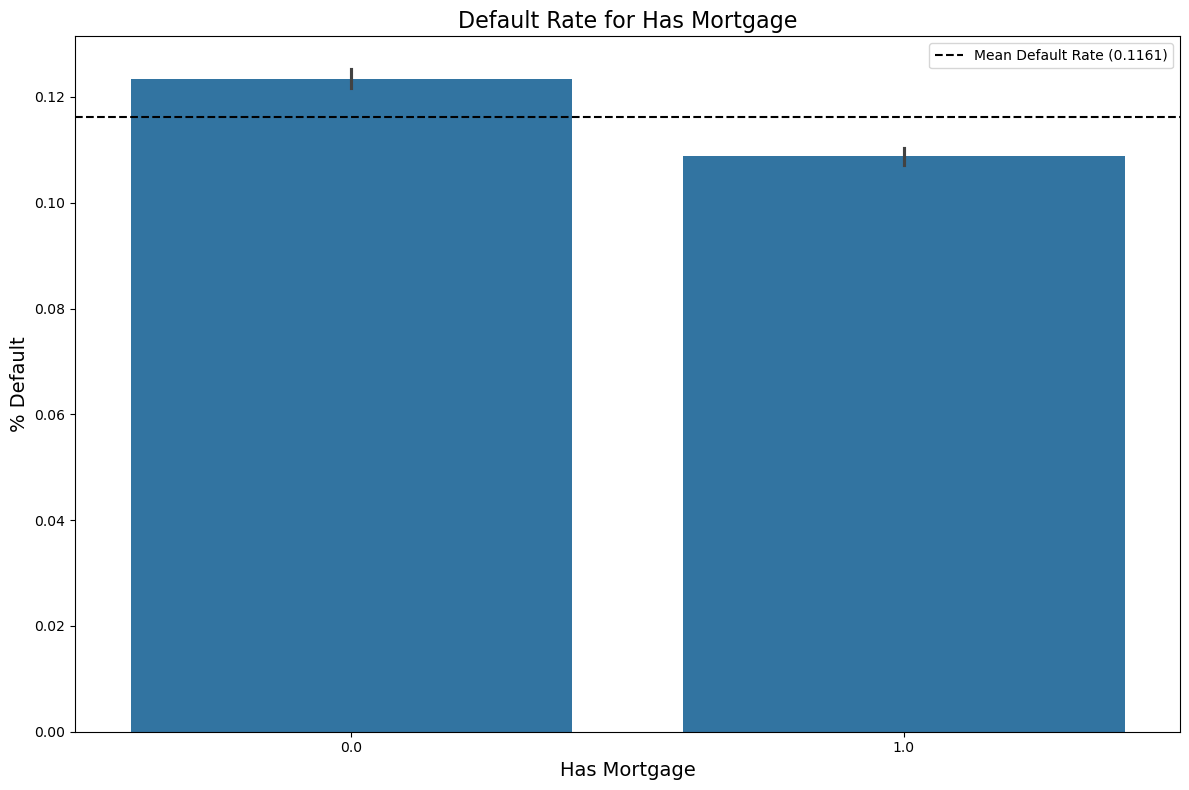

In [29]:
generate_barplot('has_mortgage', 'Default', df_defaultNotNull)

In [30]:
run_chi2_test('has_mortgage', 'Default', df_defaultNotNull)

Chi-Squared Test Results:
	Chi-Squared Statistic: 133.2520
	P-Value: 7.963383224552752e-31
	Degrees of Freedom: 1

Result: There is a statistically significant association between the variables.


## Loan Purpose

In [31]:
df_defaultNotNull['LoanPurpose'].value_counts()

LoanPurpose
Business     51298
Home         51286
Education    51005
Other        50914
Auto         50844
Name: count, dtype: int64

In [32]:
df_defaultNotNull['loan_purpose'] = clean_string('LoanPurpose', df_defaultNotNull)

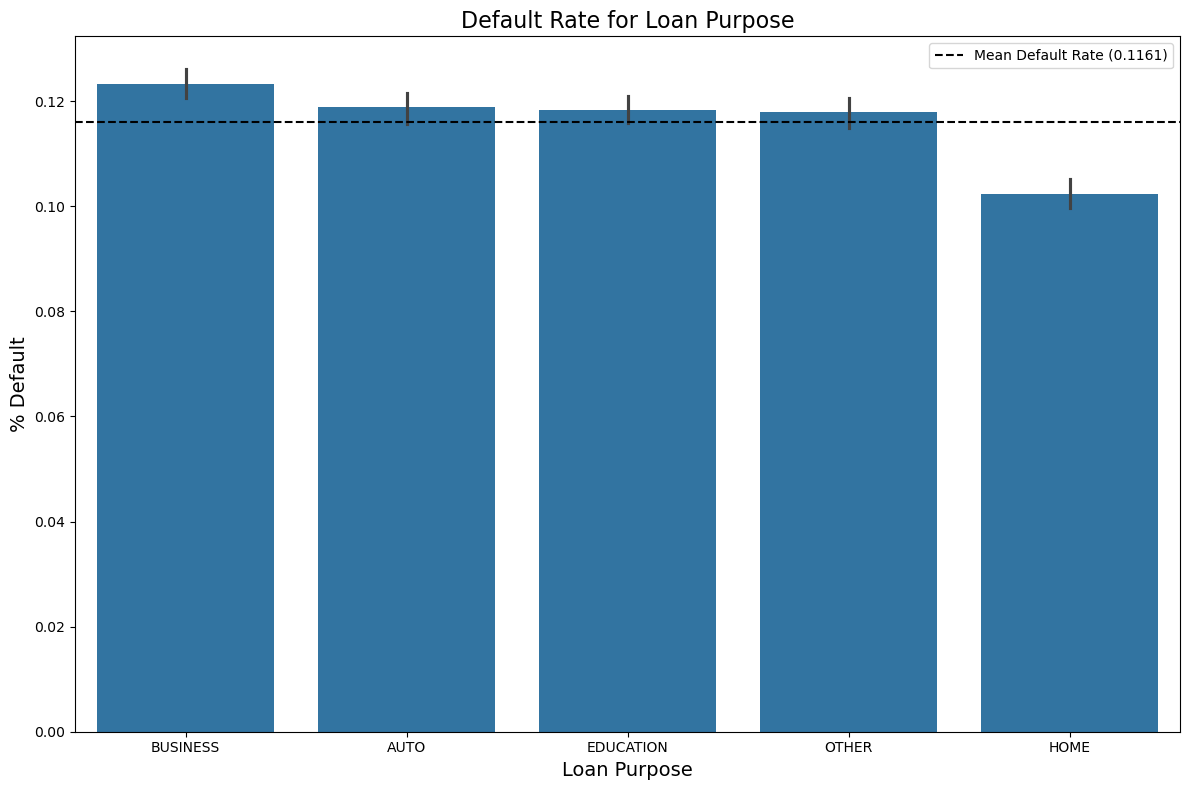

In [33]:
generate_barplot('loan_purpose', 'Default', df_defaultNotNull)

In [34]:
run_chi2_test('loan_purpose', 'Default', df_defaultNotNull)

Chi-Squared Test Results:
	Chi-Squared Statistic: 127.9342
	P-Value: 1.0767865809403042e-26
	Degrees of Freedom: 4

Result: There is a statistically significant association between the variables.


## Has Co-Signer

In [35]:
df_defaultNotNull["HasCoSigner"].value_counts()

HasCoSigner
Yes    127701
No     127646
Name: count, dtype: int64

In [36]:
df_defaultNotNull['has_cosigner'] = clean_binary('HasCoSigner', df_defaultNotNull)

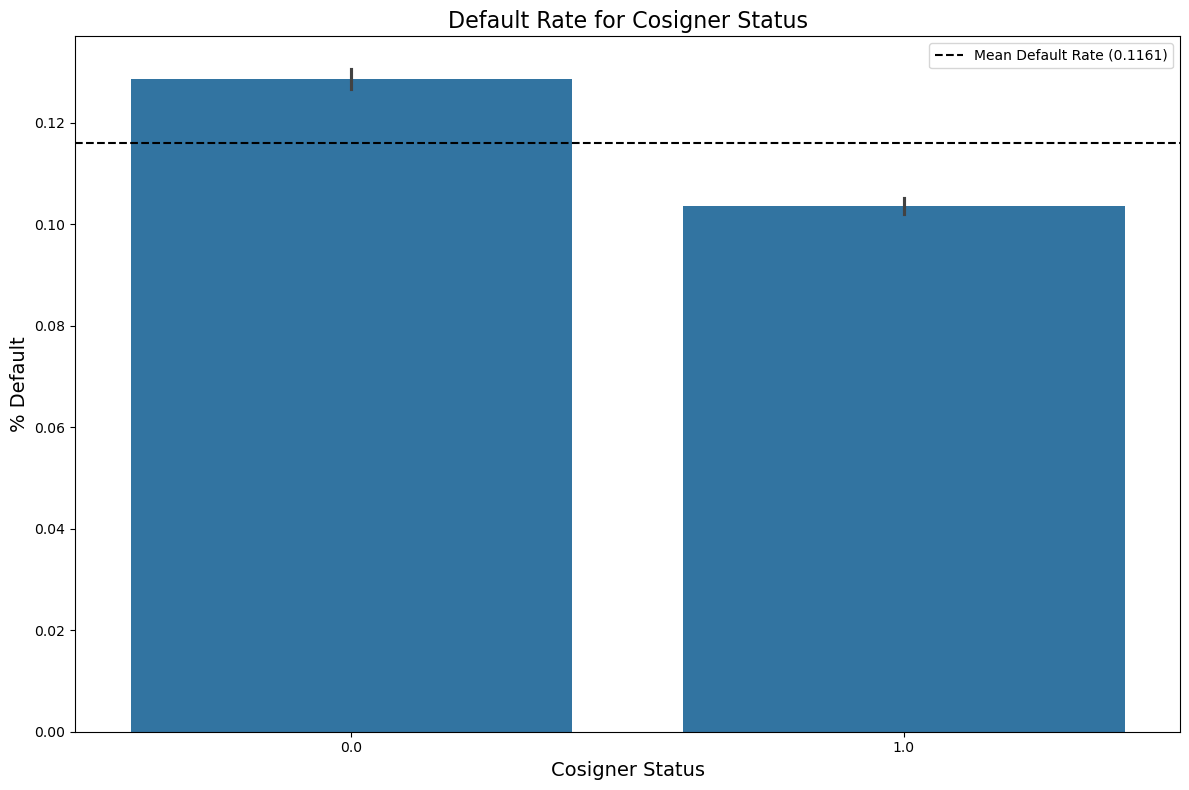

In [37]:
generate_barplot('has_cosigner', 'Default', df_defaultNotNull, "Cosigner Status")

In [38]:
run_chi2_test('has_cosigner', 'Default', df_defaultNotNull)

Chi-Squared Test Results:
	Chi-Squared Statistic: 390.3050
	P-Value: 7.103434211754059e-87
	Degrees of Freedom: 1

Result: There is a statistically significant association between the variables.


# Continuous Variables

## LoanAmount

In [39]:
df_defaultNotNull['LoanAmount'].describe()

count    255347.000000
mean     127578.865512
std       70840.706142
min        5000.000000
25%       66156.000000
50%      127556.000000
75%      188985.000000
max      249999.000000
Name: LoanAmount, dtype: float64

In [40]:
df_defaultNotNull['loan_amount_scaled'] = scale_data('LoanAmount', df_defaultNotNull, "standard")

In [41]:
df_defaultNotNull["loan_amount_scaled"].corr(df_defaultNotNull['Default'])

np.float64(0.08665917723783717)

In [42]:
df_defaultNotNull['loan_amount_scaled'].describe()

count    2.553470e+05
mean     4.082156e-17
std      1.000002e+00
min     -1.730348e+00
25%     -8.670578e-01
50%     -3.227743e-04
75%      8.668216e-01
max      1.728108e+00
Name: loan_amount_scaled, dtype: float64

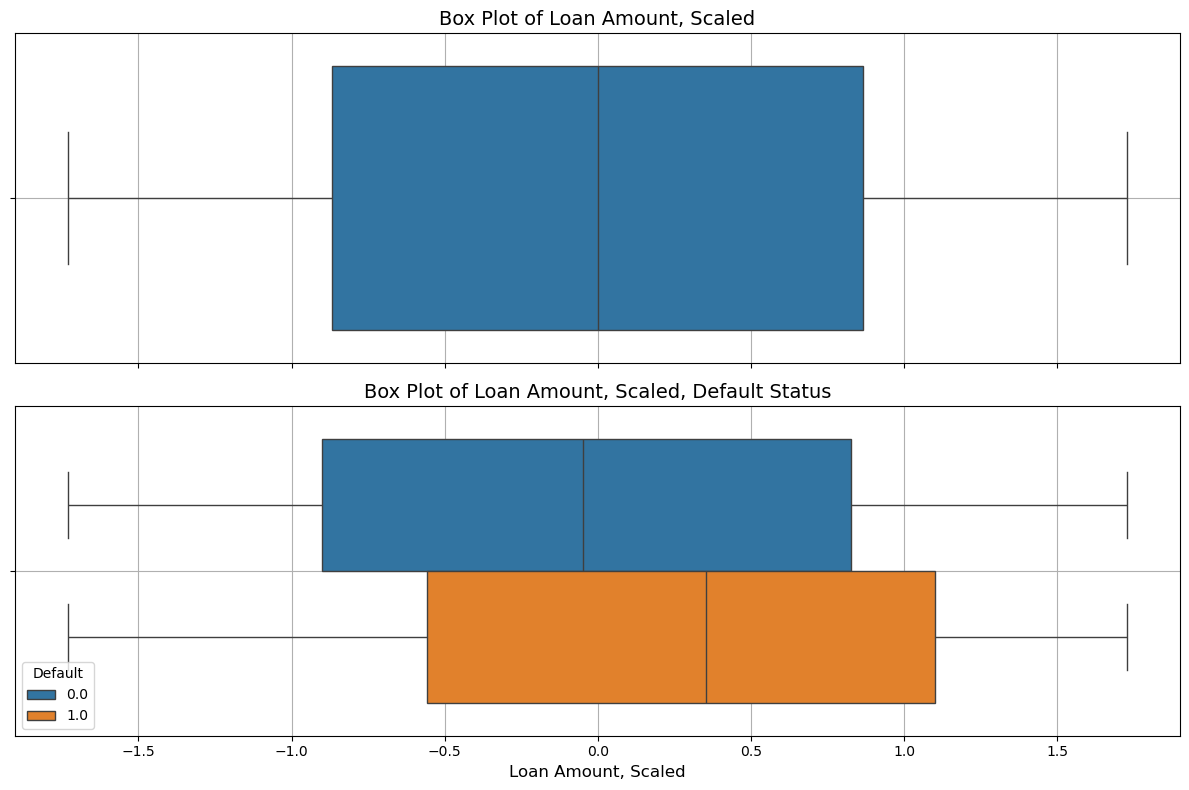

In [43]:
generate_boxplot('loan_amount_scaled', 'Default', df_defaultNotNull, "Loan Amount, Scaled")

## Months Employed

In [44]:
df_defaultNotNull['MonthsEmployed'].describe()

count    255347.000000
mean         59.541976
std          34.643376
min           0.000000
25%          30.000000
50%          60.000000
75%          90.000000
max         119.000000
Name: MonthsEmployed, dtype: float64

In [45]:
df_defaultNotNull['months_employed_scaled'] = scale_data(
    'MonthsEmployed', df_defaultNotNull, 'standard'
)

In [46]:
df_defaultNotNull['months_employed_scaled'].corr(df_defaultNotNull['Default'])

np.float64(-0.09737382897016988)

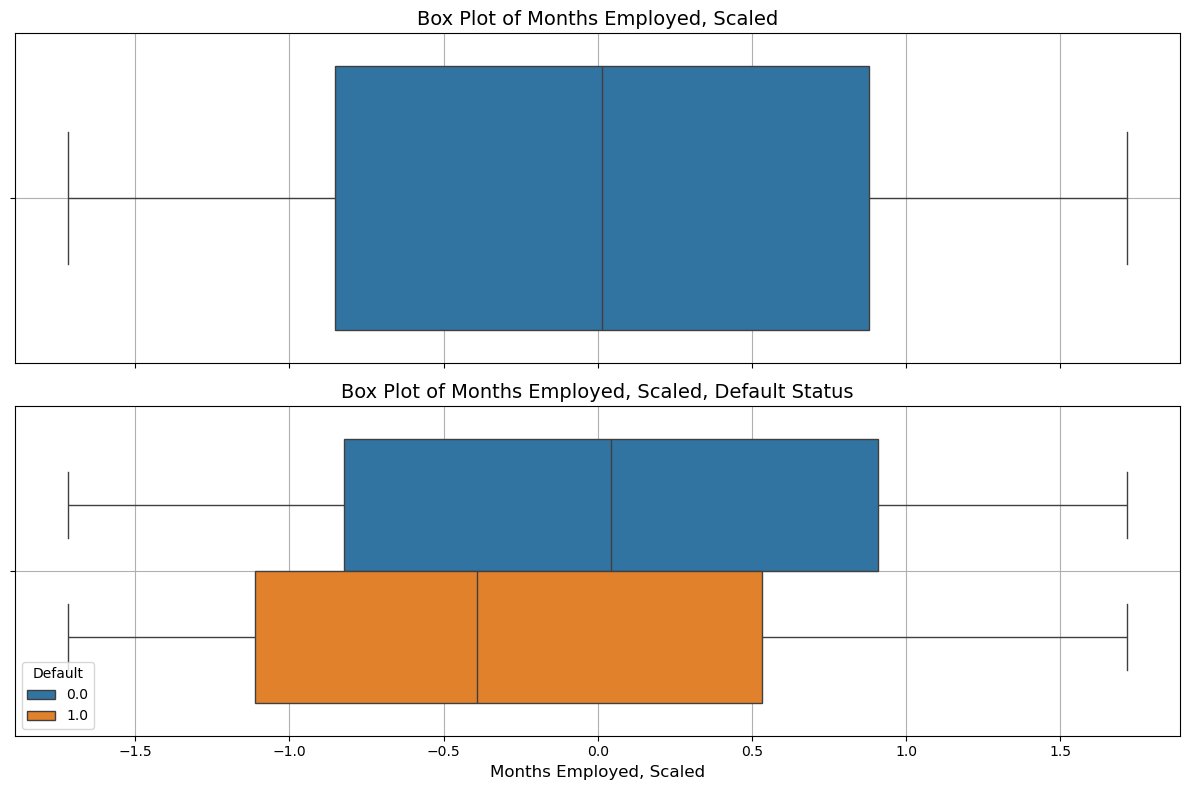

In [47]:
generate_boxplot("months_employed_scaled", "Default", df_defaultNotNull, "Months Employed, Scaled")

## Interest Rate

In [48]:
df_defaultNotNull['InterestRate'].describe()

count    255347.000000
mean         13.492773
std           6.636443
min           2.000000
25%           7.770000
50%          13.460000
75%          19.250000
max          25.000000
Name: InterestRate, dtype: float64

In [49]:
df_defaultNotNull['interest_rate_scaled'] = scale_data(
    "InterestRate", df_defaultNotNull, "standard"
)

In [50]:
df_defaultNotNull['interest_rate_scaled'].corr(df_defaultNotNull['Default'])

np.float64(0.1312730152798975)

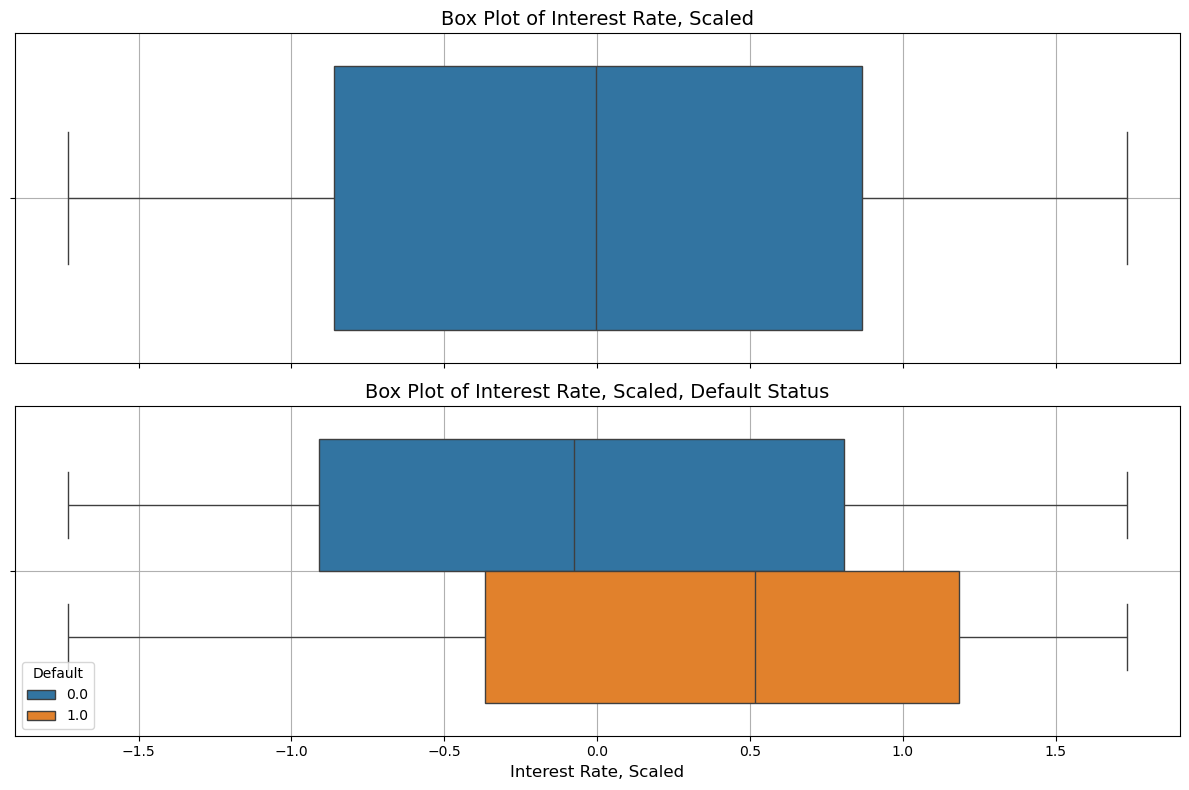

In [51]:
generate_boxplot(
    'interest_rate_scaled', 'Default', df_defaultNotNull, "Interest Rate, Scaled"
)

## DTI Ratio

In [52]:
df_defaultNotNull["DTIRatio"].describe()

count    255347.000000
mean          0.500212
std           0.230917
min           0.100000
25%           0.300000
50%           0.500000
75%           0.700000
max           0.900000
Name: DTIRatio, dtype: float64

In [53]:
df_defaultNotNull['dti_scaled'] = scale_data(
    "DTIRatio", df_defaultNotNull, "standard"
)

In [54]:
df_defaultNotNull['dti_scaled'].corr(df_defaultNotNull['Default'])

np.float64(0.019235981039708156)

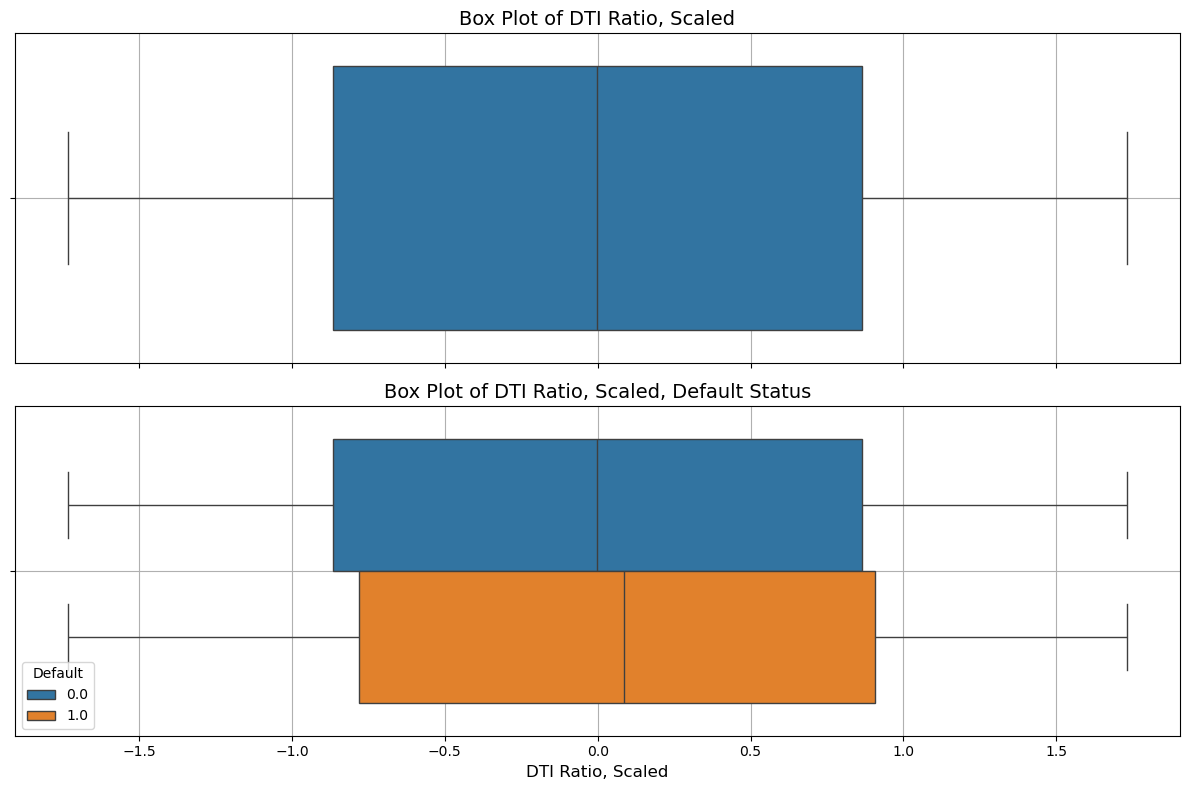

In [55]:
generate_boxplot(
    'dti_scaled', 'Default', df_defaultNotNull, 'DTI Ratio, Scaled'
)

# Build Model

### Functions

In [ ]:

def split_data(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    print(f"Percent in Training Set: {len(X_train) / len(X) * 100:.2f}%")
    print(f"Percent in Test Set: {len(X_test) / len(X) * 100:.2f}%")
    print(f"Percent in Validation Set: {len(X_val) / len(X) * 100:.2f}%")

    return X_train, X_test, X_val, y_train, y_test, y_val

## Dependent Variable

In [56]:
y = df_defaultNotNull['Default']

## Independent Variables

In [57]:
encoder = OneHotEncoder(sparse_output=False)

# Encode Categorical Variables
categorical_variables = [
    "credit_score",
    "num_credit_lines",
    "education",
    "employment_type",
    "loan_purpose"
]

X_categorical = pd.DataFrame(
    encoder.fit_transform(df_defaultNotNull[categorical_variables]),
    columns = encoder.get_feature_names_out(categorical_variables)
)

X_categorical = select_all_features(categorical_variables, y, X_categorical)

In [58]:
X_categorical.head(10)

,credit_score_POOR,education_HIGH_SCHOOL,education_PHD,employment_type_FULL_TIME,employment_type_UNEMPLOYED,loan_purpose_HOME,num_credit_lines_0.0,num_credit_lines_3.0
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
7,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Add Binary Categoricals

In [59]:
binary_categoricals = ['has_mortgage', 'has_cosigner']
for category in binary_categoricals:
    X_categorical = pd.concat([X_categorical, df_defaultNotNull[category]], axis=1)

In [60]:
X_categorical.sort_index(axis=1, inplace=True)

## Check for Multicollinearity

In [61]:
correlation_matrix = X_categorical.corr()

# Threshold for filtering
threshold = 0.7

# Get the absolute values for the correlation matrix, unstack the the 
# correlation matrix and reset the index. 
unstacked_corr_matrix = correlation_matrix.abs().unstack().reset_index()
unstacked_corr_matrix.columns = ['Feature1', 'Feature2', 'Correlation']

unstacked_corr_matrix = unstacked_corr_matrix.drop_duplicates(subset=['Correlation'])

# Filter to only those feature pairs where the value is not one and the
# absolute value is greater than the threshold
filtered_unstacked_matrix = unstacked_corr_matrix[
    (unstacked_corr_matrix['Correlation'] != 1)
    & (unstacked_corr_matrix['Correlation'] > threshold)
]

filtered_unstacked_matrix

,Feature1,Feature2,Correlation


In [63]:
# Add Continuous Variables
continuous_variables = [
    'loan_amount_scaled',
    'months_employed_scaled',
    "interest_rate_scaled",
    "dti_scaled",
]

X_continuous = df_defaultNotNull[continuous_variables]

X = pd.concat([X_categorical, X_continuous], axis=1)
X.sort_index(axis=1, ascending=True, inplace=True)
X.head(10)

,credit_score_POOR,dti_scaled,education_HIGH_SCHOOL,education_PHD,employment_type_FULL_TIME,employment_type_UNEMPLOYED,has_cosigner,has_mortgage,interest_rate_scaled,loan_amount_scaled,loan_purpose_HOME,months_employed_scaled,num_credit_lines_0.0,num_credit_lines_3.0
0,1.0,-0.260753,0.0,0.0,1.0,0.0,1.0,1.0,0.261771,-1.086833,0.0,0.590533,0.0,1.0
1,1.0,0.778585,0.0,0.0,1.0,0.0,1.0,0.0,-1.308350,-0.044309,0.0,-1.285731,1.0,0.0
2,1.0,-0.823728,0.0,0.0,0.0,1.0,0.0,1.0,1.156831,0.022715,0.0,-0.968209,0.0,0.0
3,0.0,-1.170174,1.0,0.0,1.0,0.0,0.0,0.0,-0.967805,-1.168538,0.0,-1.718715,0.0,0.0
4,0.0,0.995114,0.0,0.0,0.0,1.0,0.0,0.0,-1.052188,-1.671921,0.0,-1.487790,0.0,1.0
5,0.0,-1.733149,1.0,0.0,0.0,1.0,1.0,1.0,1.390390,-0.524147,0.0,-1.199134,0.0,0.0
6,1.0,-1.473314,0.0,0.0,0.0,1.0,1.0,1.0,0.846423,0.697992,1.0,0.590533,1.0,0.0
7,1.0,-0.304059,0.0,1.0,1.0,0.0,1.0,0.0,-0.805067,0.394296,1.0,0.215280,0.0,1.0
8,0.0,-1.300091,0.0,0.0,0.0,0.0,0.0,1.0,1.574224,-0.497199,0.0,0.677130,1.0,0.0
9,1.0,-0.737116,1.0,0.0,0.0,0.0,1.0,1.0,-0.663425,1.424765,0.0,1.571964,0.0,1.0


## Split Data

In [77]:
X_train, X_test, X_val, y_train, y_test, y_val = split_data(X, y)

Percent in Training Set: 70.00%
Percent in Test Set: 15.00%
Percent in Validation Set: 15.00%
